Pos Tech - MLET - Tech Challenge - Fase 4

Usar a versão Python 3.10.6 no Kernel

[*********************100%%**********************]  1 of 1 completed

Epoch 1/10



c:\Users\lucia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0101 - val_loss: 7.6622e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.6258e-04 - val_loss: 0.0011
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.8362e-04 - val_loss: 9.5603e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.4974e-04 - val_loss: 0.0070
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.1822e-04 - val_loss: 0.0016
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.6185e-04 - val_loss: 0.0030
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.5830e-04 - val_loss: 0.0012
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.1361e-04 - val_loss: 0.0013
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.6908e-04 - val_loss: 0.0012
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.4841e-04 - val_loss: 0.0025


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
MAE: 19.28
RMSE: 22.12
MAPE: 5.61%


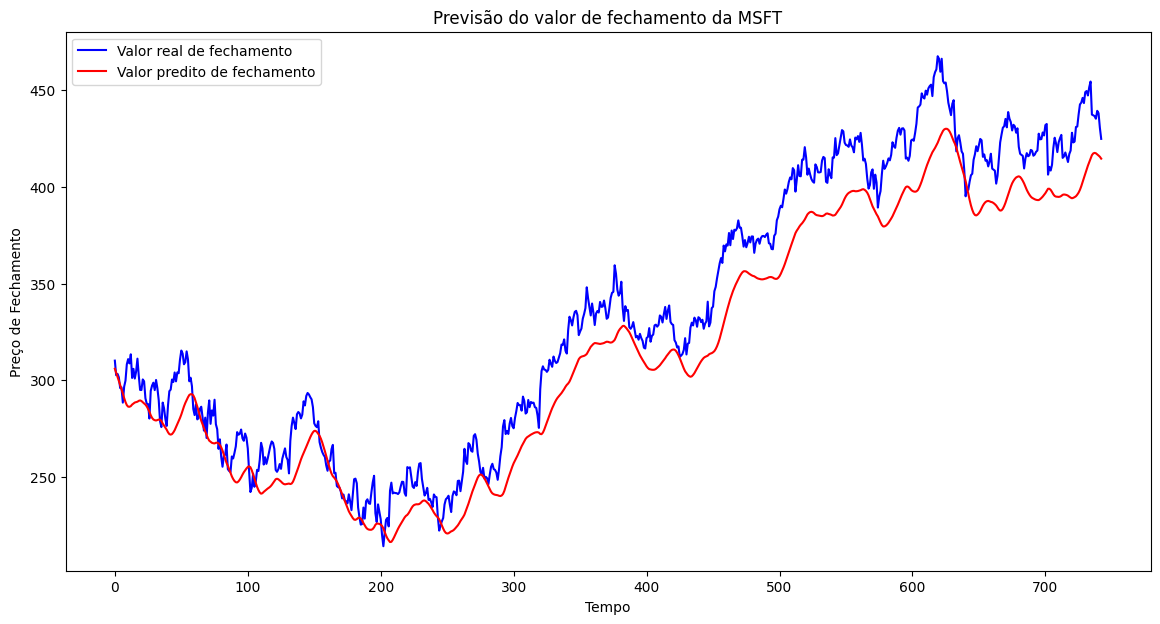

INFO:     Started server process [17880]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import joblib
from fastapi import FastAPI
import uvicorn
import nest_asyncio
from pydantic import BaseModel
from typing import List

# --- 1. BAIXAR DADOS HISTÓRICOS ---
data = yf.download('MSFT', start='2010-01-01', end='2025-01-01')
data = data[['Close']]  # Apenas preço de fechamento

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Salvar o scaler para reutilização na API
joblib.dump(scaler, "scaler.pkl")

# Criar dataset para treino (últimos 60 dias preveem o próximo)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape para LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- 2. CONSTRUIR E TREINAR O MODELO LSTM ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Salvar o modelo treinado
model.save("lstm_model.h5")

# --- 3. AVALIAÇÃO DO MODELO ---
predictions = model.predict(X_test)

# Reverter a normalização
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo das métricas de erro
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_test_rescaled, predictions)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
mape = mean_absolute_percentage_error(y_test_rescaled, predictions)

# Exibir métricas
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plotar resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, color='blue', label='Valor real de fechamento')
plt.plot(predictions, color='red', label='Valor predito de fechamento')
plt.title('Previsão do valor de fechamento da MSFT')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

# --- 4. CRIAÇÃO DA API COM FASTAPI ---

# Criar a API
app = FastAPI()

# Definir o modelo de entrada
class PriceHistoryRequest(BaseModel):
    price_history: List[float]

# Rota para previsão
@app.post("/predict/")
def predict(request: PriceHistoryRequest):
    """
    Recebe um array com os últimos 60 preços de fechamento e retorna a previsão do próximo dia.
    """
    if len(request.price_history) != 60:
        return {"error": "Forneça exatamente 60 preços de fechamento para previsão."}

    # Carregar modelo e scaler
    model = load_model("lstm_model.h5")
    scaler = joblib.load("scaler.pkl")

    # Normalizar os dados de entrada
    price_history = np.array(request.price_history).reshape(-1, 1)
    price_history_scaled = scaler.transform(price_history)

    # Ajustar formato para entrada na LSTM
    X_input = np.array(price_history_scaled).reshape(1, 60, 1)

    # Fazer previsão
    prediction = model.predict(X_input)

    # Converter de volta ao valor original
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    return {"predicted_price": round(predicted_price, 2)}

# Executar a API no Jupyter Notebook
nest_asyncio.apply()
uvicorn.run(app, host="127.0.0.1", port=8000)

### Explicação do código:

1. **Obtenção dos dados**: Utilizamos a API `yfinance` para baixar os dados históricos de ações da Microsoft (MSFT) de 2010 a 2025. O foco é no preço de fechamento.

2. **Pré-processamento dos dados**:
   - A escala dos dados é ajustada para o intervalo de 0 a 1 usando `MinMaxScaler`, que ajuda a LSTM a aprender de maneira mais eficiente.
   - A função `create_dataset` cria sequências de dados (time series), onde usamos os últimos 60 dias para prever o próximo dia.

3. **Construção do modelo LSTM**:
   - O modelo é construído com duas camadas LSTM, seguidas de camadas Dropout para prevenir overfitting.
   - A última camada é uma camada `Dense` com uma única unidade de saída para prever o valor de fechamento.

4. **Treinamento e Previsões**:
   - O modelo é treinado por 10 épocas (esse número pode ser ajustado conforme necessário).
   - As previsões são feitas no conjunto de teste e são revertidas para a escala original.

5. **Avaliação do modelo**:
   - O modelo é avaliado usando métricas estatísticas após fazer previsões nos dados de teste.
   - Utilizamos três métricas principais:
     - **MAE (Erro Absoluto Médio)**: Mede o erro médio absoluto das previsões. Quanto menor, melhor. Indica a média da diferença absoluta entre o valor real e o predito.
     - **RMSE (Erro Quadrático Médio)**: Dá maior peso a erros maiores, útil para entender a variação dos erros. Deve ser próximo do MAE, mas penaliza grandes desvios.
     - **MAPE (Erro Percentual Absoluto Médio)**: Mede o erro percentual das previsões em relação ao valor real. Indica o erro médio percentual em relação ao valor real (exemplo: um MAPE de 5% significa que as previsões erram, em média, 5% do valor real).

6. **Visualização**: O gráfico mostra as previsões (linha vermelha) comparadas com os valores reais de fechamento (linha azul).

7. **Como Usar a API**:
   - Acessar no navegador:
      - Abra o navegador e vá para:
         👉 http://127.0.0.1:8000/docs
         Aqui, você pode testar a API diretamente pelo Swagger UI.

   - Fazer uma previsão via cURL ou Postman: Envie uma requisição POST para http://127.0.0.1:8000/predict/ com um JSON contendo 60 preços anteriores:

### Resultados:
- O modelo fornecerá uma previsão do valor de fechamento das ações da Microsoft para os próximos dias com base nas últimas 60 observações.
- A precisão do modelo pode ser melhorada ajustando hiperparâmetros como número de épocas, unidades LSTM, etc.